<h1 align=center>2-8 综合案例：航班晚点预测</h1>

## 目录

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <li><a href="#ref0">实验导览</a></li>
    <li><a href="#ref1">导入数据</a></li>
    <li><a href="#ref2">整理数据</a></li>
    <li><a href="#ref10">哪个城市起飞的航港延迟最严重？</a></li>
    <li><a href="#ref10">哪条航线最容易产生延迟 ？</a></li>
    <li><a href="#ref10">一年里哪个月份航班晚点的情况最严重？</a></li>
    <li><a href="#ref10">什么时间航班晚点发送的情况最多？</a></li>
    <li><a href="#ref10">模型：逻辑回归</a></li>
</div>

## 1. 实验目标
通过建立逻辑回归模型，对航班进行延误的可能性实现准确预测。

## 2. 实验内容描述
在本次案例中，我们对不同航班、不同时间点、不同航线的延误情况进行了绘图分析，并且建立逻辑回归模型，使用训练集数据去优化模型，得到一个高准确度的模型，最终实现对航班延误可能性的精准预测。

## 3. 适用的对象
### 3.1 学习者
     大数据分析人员  学生             
### 3.2 课程
     大数据分析  AI 算法

## 4. 流程图

<img src = "http://d-labs.oss-cn-shanghai.aliyuncs.com/datasets/%E8%88%AA%E7%8F%AD%E6%99%9A%E7%82%B9.jpg", width = 950/>

本案例中我们将利用美国航空的航班公共数据集，根据过往的航班晚点数据进行分析和预测。我们将使用Jupyter Notebook进行数据的读取，分析以及结果的可视化。

这个案例中使用的数据集是美国所有航空公司2007全年的航班信息，约包含700万条航班信息。

注：本案例运行的结果以及包含，可清除运行结果后，自行再次运行。

<h4>首先，让我们安装本次实验将要用到的库</h4>

In [1]:
!pip install pillow -i http://mirrors.aliyun.com/pypi/simple --trusted-host mirrors.aliyun.com
!pip install --no-deps torchvision -i http://mirrors.aliyun.com/pypi/simple --trusted-host mirrors.aliyun.com
!pip install torch -i http://mirrors.aliyun.com/pypi/simple --trusted-host mirrors.aliyun.com

    100% |████████████████████████████████| 27.2MB 47.7MB/s  0:00:0111


<h4>然后，让我们声明需要的 Python 库</h4>

In [1]:
import math
from pandas.core.frame import DataFrame
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 导入数据

读取数据集文件 airline2007.csv，可能需要几分钟时间

In [3]:
airline_df = pd.read_csv('airline2008.csv')

## 数据整理

这里，我们增加一个新的字段 **DepDelayed**, 一个布尔类型，表明该航班是否算作延迟:
- **True**, 如果航班时间到达时间与预定时间晚于15分钟以上
- **False**, 如果航班时间到达时间与预定时间小于15分钟以内

我们将会使用 **Depdelayed** 作为接下来分类处理中的一个属性字段

In [4]:
airline_df['DepDelayed'] = airline_df['DepDelay']>15

## 数据分析

让我们先开始做一些简单的数据分析  

### 数据分析 1 :  哪个城市起飞的航港延迟最严重？

In [5]:
groupedDelay = airline_df.groupby(['Origin'], as_index=False)['DepDelay'].mean().rename(columns={'DepDelay': 'delay'})
groupedcount = airline_df.groupby(['Origin'], as_index=False)['Year'].count().rename(columns={'Year': 'conFlight'})
df_origin = pd.merge(groupedDelay,groupedcount,on = 'Origin')
df_origin = df_origin.sort_values(by=["delay"],ascending=False)
df_origin.head()

,Origin,delay,conFlight
66,CMX,116.147059,34
225,PLN,93.761905,21
272,SPI,83.848739,357
14,ALO,82.225806,31
195,MQT,79.556650,203


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> 练习 1: </h1>
<b>哪个城市到达的的航港延迟最严重？<br>
请统计每个到达航港平均延迟时间，并排序，显示延迟最严重的5个航港。（到达港为“Dest”）</b>
</div>

In [6]:
#请在这里输入您的代码
groupedDelay = airline_df.groupby(['Dest'], as_index=False)['DepDelay'].mean().rename(columns={'DepDelay': 'delay'})
groupedcount = airline_df.groupby(['Dest'], as_index=False)['Year'].count().rename(columns={'Year': 'conFlight'})
df_Dest = pd.merge(groupedDelay,groupedcount,on = 'Dest')
df_Dest = df_Dest.sort_values(by=["delay"],ascending=False)
df_Dest.head()


,Dest,delay,conFlight
196,MQT,77.384259,432
273,SPI,69.928934,394
177,MCN,67.569061,181
142,INL,67.444444,9
283,TEX,66.312500,32


 <div align="right">
<a href="#q1" class="btn btn-default" data-toggle="collapse">点击获取答案</a>

</div>
<div id="q1" class="collapse">
```
代码：
groupedDelay = airline_df.groupby(['Dest'], as_index=False)['DepDelay'].mean().rename(columns={'DepDelay': 'delay'})
groupedcount = airline_df.groupby(['Dest'], as_index=False)['Year'].count().rename(columns={'Year': 'conFlight'})
df_Dest = pd.merge(groupedDelay,groupedcount,on = 'Dest')
df_Dest = df_Dest.sort_values(by=["delay"],ascending=False)
df_Dest.head()
   
```
</div>


__注:__ 为了可以根据经纬度，在地图上标注每个城市航站的位置，我们运行下面的代码

In [7]:
df = pd.read_csv('airports.csv', index_col=0,\
names = ['name', 'city', 'country','IATA','ICAO','lat','lng','alt','TZone','DST','Tz','airport','OurAirports'], \
            header=0)

In [8]:
df_airports = pd.merge(df_origin, df, left_on = 'Origin', right_on = 'IATA')
df_airports.head()

,Origin,delay,conFlight,name,city,country,IATA,ICAO,lat,lng,alt,TZone,DST,Tz,airport,OurAirports
0,CMX,116.147059,34,Houghton County Memorial Airport,Hancock,United States,CMX,KCMX,47.168400,-88.489098,1095,-5,A,America/New_York,airport,OurAirports
1,PLN,93.761905,21,Pellston Regional Airport of Emmet County Airport,Pellston,United States,PLN,KPLN,45.570900,-84.796700,721,-5,A,America/New_York,airport,OurAirports
2,SPI,83.848739,357,Abraham Lincoln Capital Airport,Springfield,United States,SPI,KSPI,39.844101,-89.677902,598,-6,A,America/Chicago,airport,OurAirports
3,ALO,82.225806,31,Waterloo Regional Airport,Waterloo,United States,ALO,KALO,42.557098,-92.400299,873,-6,A,America/Chicago,airport,OurAirports
4,MQT,79.556650,203,Sawyer International Airport,Gwinn,United States,MQT,KSAW,46.353600,-87.395401,1221,-5,A,America/New_York,airport,OurAirports


In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def zscore(x):
    return (x-np.mean(x))/np.std(x)

绘制结果图：

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


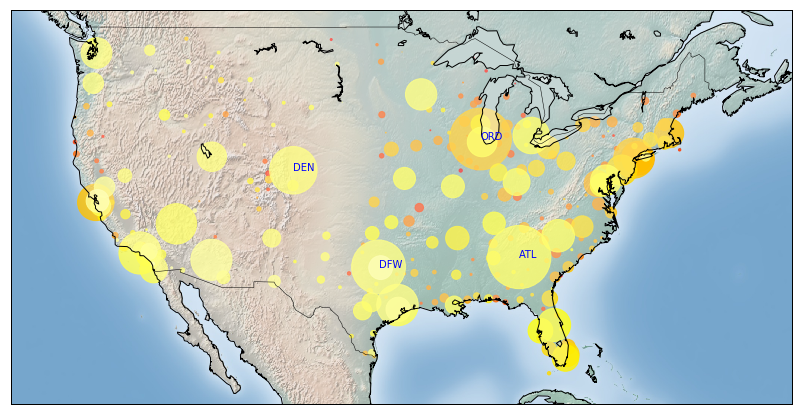

In [10]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (14,10)


my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #最小经度 (llcrnrlon) 和纬度 (llcrnrlat) 
            urcrnrlon=-60, urcrnrlat=50) #最大经度  (urcrnrlon) 和纬度 (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# 创建一个色彩地图
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#-----散点图 -------
countrange=max(df_airports['conFlight'])-min(df_airports['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports['delay'])])
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
val=df_airports['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- 文本 -------
df_text=df_airports[(df_airports['conFlight']>60000) & (df_airports['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> 练习 2: </h1>
<b>利用练习一中的数据，绘制到达港延迟及繁忙程度地图，比较两者。<br>
</b>
</div>

Each marker is an airport.
Size of markers: Airport Traffic (larger means higher number of flights in year)
Color of markers: Average Flight Delay (Redder means longer delays)


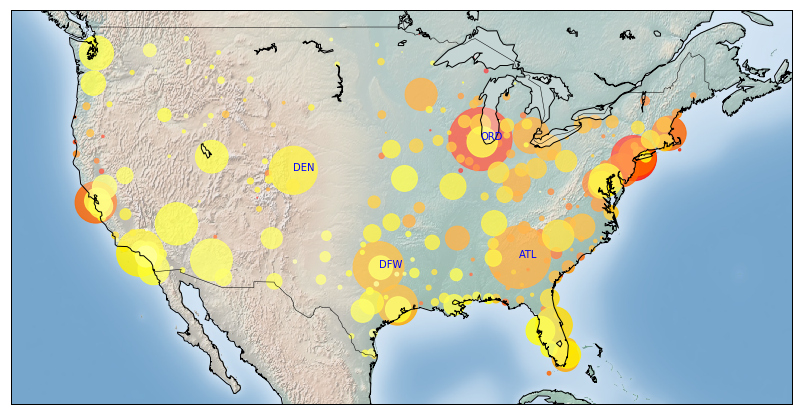

In [11]:
#请在这里输入您的代码
rcParams['figure.figsize'] = (14,10)
df_airports_Dest = pd.merge(df_Dest, df, left_on = 'Dest', right_on = 'IATA')
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #最小经度 (llcrnrlon) 和纬度 (llcrnrlat) 
            urcrnrlon=-60, urcrnrlat=50) #最大经度  (urcrnrlon) 和纬度 (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#-----散点图 -------
countrange=max(df_airports_Dest['conFlight'])-min(df_airports_Dest['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports_Dest['delay'])])
xs,ys = my_map(np.asarray(df_airports_Dest['lng']), np.asarray(df_airports_Dest['lat']))
val=df_airports_Dest['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- 文本 -------
df_text=df_airports_Dest[(df_airports_Dest['conFlight']>60000) & (df_airports_Dest['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()


 <div align="right">
<a href="#q2" class="btn btn-default" data-toggle="collapse">点击获取答案</a>

</div>
<div id="q2" class="collapse">
```
代码：
rcParams['figure.figsize'] = (14,10)
df_airports_Dest = pd.merge(df_Dest, df, left_on = 'Dest', right_on = 'IATA')
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #最小经度 (llcrnrlon) 和纬度 (llcrnrlat) 
            urcrnrlon=-60, urcrnrlat=50) #最大经度  (urcrnrlon) 和纬度 (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 30))
colors=np.flipud(colors)

#-----散点图 -------
countrange=max(df_airports_Dest['conFlight'])-min(df_airports_Dest['conFlight'])
al=np.array([sigmoid(x) for x in zscore(df_airports_Dest['delay'])])
xs,ys = my_map(np.asarray(df_airports_Dest['lng']), np.asarray(df_airports_Dest['lat']))
val=df_airports_Dest['conFlight']*4000.0/countrange

my_map.scatter(xs, ys,  marker='o', s= val, alpha = 0.8,color=colors[(al*20).astype(int)])

#----- 文本 -------
df_text=df_airports_Dest[(df_airports_Dest['conFlight']>60000) & (df_airports_Dest['IATA'] != 'HNL')]
xt,yt = my_map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['IATA'])
zp=zip(xt,yt,txt)
for row in zp:
    #print zp[2]
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each marker is an airport.")
print("Size of markers: Airport Traffic (larger means higher number of flights in year)")
print("Color of markers: Average Flight Delay (Redder means longer delays)")

plt.show()
   
```
</div>


### 数据分析 2 : 哪条航线最容易产生延迟 ？

In [12]:
grp_rout_Delay = airline_df.groupby(['Origin','Dest'],as_index=False)['Distance','DepDelay'].mean().rename(columns={'Distance': 'avgDist','DepDelay':'avgDelay'})
grp_count = airline_df.groupby(['Origin','Dest'], as_index=False)['Year'].count().rename(columns={'Year': 'traffic'})
rout_Delay = pd.merge(grp_rout_Delay,grp_count,left_on = ['Origin','Dest'],right_on =['Origin','Dest'])
rout_Delay = rout_Delay.sort_values(by=["avgDelay"],ascending=False)
rout_Delay.head()

,Origin,Dest,avgDist,avgDelay,traffic
1004,CMI,SPI,76,587.0,1
4521,SDF,SPI,241,329.0,1
4646,SFO,SMX,216,325.0,1
2104,HPN,PIA,836,298.0,1
4298,ROA,CVG,282,255.0,1


In [13]:
df_airport_rout1 = pd.merge(rout_Delay, df, left_on = 'Origin', right_on = 'IATA')
df_airport_rout2 = pd.merge(df_airport_rout1, df, left_on = 'Dest', right_on = 'IATA')
df_airport_rout = df_airport_rout2[["Origin","lat_x","lng_x","Dest","lat_y","lng_y",\
                                    "avgDelay", "traffic"]]

统计分析并绘制结果图：

Each line represents a route from the Origin to Destination airport.
The redder line, the higher probablity of delay.


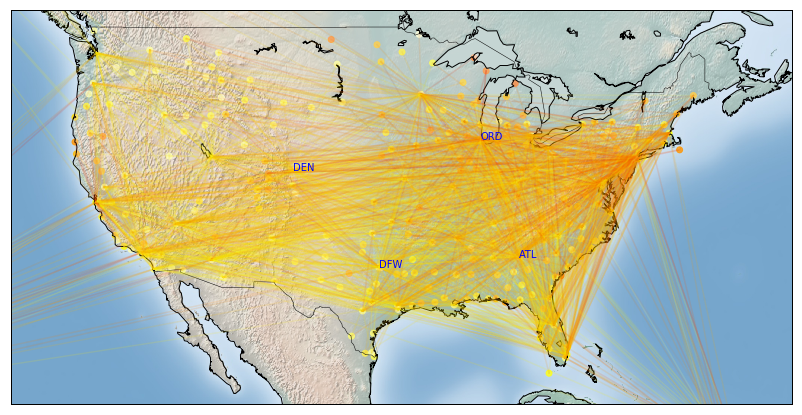

In [14]:
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=-130, llcrnrlat=22, #最小经度 (llcrnrlon) 和纬度 (llcrnrlat) 
            urcrnrlon=-60, urcrnrlat=50) #大经度  (urcrnrlon) 和纬度 (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

delay=np.array([sigmoid(x) for x in zscore(df_airports["delay"])])
colors = plt.get_cmap('hot')(np.linspace(0.0, 1.0, 40))
colors=np.flipud(colors)
xs,ys = my_map(np.asarray(df_airports['lng']), np.asarray(df_airports['lat']))
xo,yo = my_map(np.asarray(df_airport_rout['lng_x']), np.asarray(df_airport_rout['lat_x']))
xd,yd = my_map(np.asarray(df_airport_rout['lng_y']), np.asarray(df_airport_rout['lat_y']))

my_map.scatter(xs, ys,  marker='o',  alpha = 0.8,color=colors[(delay*20).astype(int)])


al=np.array([sigmoid(x) for x in zscore(df_airport_rout["avgDelay"])])
f=zip(xo,yo,xd,yd,df_airport_rout['avgDelay'],al)
for row in f:
    plt.plot([row[0],row[2]], [row[1],row[3]],'-',alpha=0.07 ,color=colors[np.int16(row[5]*30)] )
zp=zip(xt,yt,txt)
for row in zp:
    plt.text(row[0],row[1],row[2], fontsize=10, color='blue',)

print("Each line represents a route from the Origin to Destination airport.")
print("The redder line, the higher probablity of delay.")
    
plt.show()



### 数据分析 3 :  一年里哪个月份航班晚点的情况最严重？

选择肯尼迪机场（JFK）来进行分析，

In [15]:
Origin_Airport="JFK"

In [16]:
df_ORG = airline_df[airline_df['Origin']==Origin_Airport]

我们看看从这个航港起飞的航班数量情况

In [17]:
print("从此航港起飞的航班总数 : " + str(df_ORG.count()[0]))

从此航港起飞的航班总数 : 34706


这里，我们根据月份分类，来看看航班晚点的情况:

In [18]:
grp_carr = df_ORG[df_ORG.DepDelayed==True]
grp_carr = grp_carr.groupby(['UniqueCarrier','Month'], as_index=False)['DepDelay'].mean()
grp_carr = DataFrame(grp_carr)
grp_carr = grp_carr.rename(columns={'DepDelay': 'avgDelay'})

In [19]:
ps = grp_carr.pivot(index='Month', columns='UniqueCarrier', values='avgDelay')[['AA','UA','US']]

绘制结果图

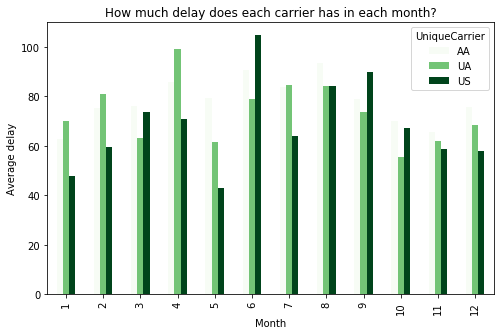

In [20]:
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Greens');
plt.xlabel('Month')
plt.ylabel('Average delay')
plt.title('How much delay does each carrier has in each month?')

我们可以看到，三个航空公司不同月份晚点情况不同，例如：全美航空在6月和8月是一年中航班晚点情况最严重的月份。

* AA - 代表美国航空
* UA - 代表美国联合航空
* US - 代表全美航空

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> 练习 3: </h1>
<b>请通过对上文中的参数进行修改，将条形图的颜色修改为红色。</b>
</div>

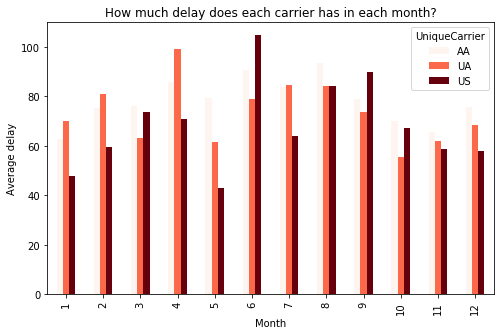

In [21]:
#请在这里输入您的代码

rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Reds');
plt.xlabel('Month')
plt.ylabel('Average delay')
plt.title('How much delay does each carrier has in each month?')


 <div align="right">
<a href="#q3" class="btn btn-default" data-toggle="collapse">点击获取答案</a>

</div>
<div id="q3" class="collapse">
```
代码：
rcParams['figure.figsize'] = (8,5)
ps.plot(kind='bar', colormap='Reds');
plt.xlabel('Month')
plt.ylabel('Average delay')
plt.title('How much delay does each carrier has in each month?')
   
```
</div>


### 数据分析 4 :  什么时间航班晚点发送的情况最多？

In [22]:
df_ORG['hour'] = round(df_ORG['CRSDepTime']/100)

In [23]:
hour_grouped = df_ORG[df_ORG.DepDelayed==True]
hour_grouped = hour_grouped.groupby(['DayOfWeek','hour'], as_index=False)['DepDelay'].mean()
dh = DataFrame(hour_grouped)

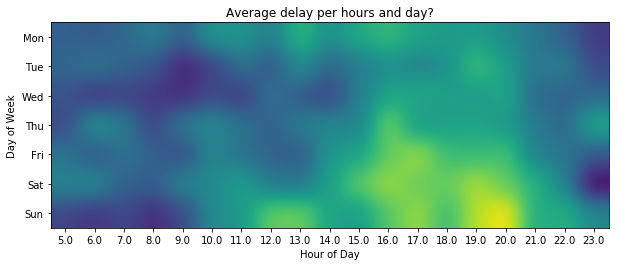

In [24]:
rcParams['figure.figsize'] = (10,5)
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values[3:24]
Y = c.index.values
Z = c.values[:,4:24]
plt.xticks(range(0,24), X)
plt.yticks(range(0,7),['Mon','Tue','Wed','Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z,interpolation ='gaussian')

这个热度图非常清晰的告诉了我们晚点的航班分布（颜色越偏暖色调，说明航班晚点发生的航班数量越多），可以看到:

- 每天的16:00 - 20:00 普遍晚点航班较多：其中可能的原因是这是下班高峰，且每天前序航班叠加到下午或者更晚的时候，导致更多的晚点
- 每周六周日的航班晚点也比较严重，可能周末出行人数比较多。

## 建模分析: 逻辑回归

在这一部分，我们将建立一个有监督的学习模型来预测离开我们选定机场的航班的航班延误。


In [25]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import numpy as np
%matplotlib inline

### 预处理 1 : 选择需要的属性来分析建模

我们选择了 月份、日期、钟点、目标机场名称 4个属性<br>
标签为  DepDelayed 是否延误。

In [26]:
x1 = df_ORG[['Month','DayofMonth','hour','Dest']]
x2 = pd.get_dummies(x1)
x_np = np.array(x2)

y = df_ORG['DepDelayed']
y_np = (np.array(y) + 0).reshape(len(y),1)

Dest_names = x2.columns.values.tolist()[3:71]

### 预处理 2 :  将数据分为训练和测试数据

In [27]:
data = np.hstack([x_np,y_np])
train_data, test_data = train_test_split(data, test_size=0.3, random_state=1)

In [28]:
# 需要将变量转化为 torch 中的张量形式
x_torch = torch.from_numpy(train_data[:,0:-1]).float()
y_torch = torch.from_numpy(train_data[:,-1].reshape(len(train_data[:,-1]),1)).float()

x_data = Variable(x_torch)
y_data = Variable(y_torch)

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> 练习 4: </h1>
<b>如何将训练集和测试集的数据按照6:4的比例进行划分呢？</b>
</div>

In [29]:
#请在这里输入您的代码
train_data, test_data = train_test_split(data, test_size=0.4, random_state=1)

 <div align="right">
<a href="#q4" class="btn btn-default" data-toggle="collapse">点击获取答案</a>

</div>
<div id="q4" class="collapse">
```
代码：
train_data, test_data = train_test_split(data, test_size=0.4, random_state=1)
   
```
</div>


### 创建模型

In [30]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(70, 1) # 
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        y_pred = self.sigmoid(self.linear(x))
        return y_pred

In [31]:
model = Model()
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**开始训练**

In [32]:
%%time
for epoch in range(500):
    y_pred = model(x_data)
    # 计算损失
    loss = criterion(y_pred, y_data)
    # 初始化梯度
    optimizer.zero_grad()
    # 反向传递误差
    loss.backward()
    # 更新权重
    optimizer.step()
print("Finished!")

Finished!
CPU times: user 1.64 s, sys: 76.8 ms, total: 1.72 s
Wall time: 994 ms


## 模型的评估

In [33]:
x_test_data = torch.from_numpy(test_data[:,0:-1]).float()
x_test = Variable(x_test_data)
result = model.forward(x_test)
y_test = test_data[:,-1].reshape(len(test_data[:,-1]),1)

resultf = (result.data.numpy()>0.5)==(y_test)+0
accuracy = sum(resultf)/len(resultf)

print( "从 JFK（纽约肯尼迪机场起飞的航班）预测准确率: %1.2f %%" % (accuracy*100))

从 JFK（纽约肯尼迪机场起飞的航班）预测准确率: 71.56 %


### 使用这个模型预测一个从 JFK 起飞的具体航班

我们使用下面的示例数据来预测：<br>
Month=8, Day=17, Hour=18, Dest=CLE（到达港为克利夫兰机场)

In [34]:
test = [8,17,18,'CLE']
test_tr = np.hstack(( (np.array(test[:3]),((np.array(Dest_names) ==('Dest_'+test[3])) +0)) ))
x_test_data = torch.from_numpy(test_tr).float()
x_test = Variable(x_test_data)
result = model.forward(x_test).data.numpy()

if result<0.5:
    print('You flight doesnt have a delay, Accuracy= %1.2f %%' % ((1-result)*100))
else:
    print('You flight may be delayed, Accuracy= %1.2f %%' % (result*100))


You flight may be delayed, Accuracy= 74.17 %
